# Практическое задание

## Вычитание фона

### О задании

В данном задании вам предлагается самостоятельно реализовать алгоритм вычитания фона ViBe. Протестировать этот алгорит на датасете ChangeDetection 2014 года, а также сравнить качество его работы с алгоритмом, основанным на смеси гауссиан. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. Необходимо установить следующие пакеты: `numpy`, `skimage`, `opencv`. 

In [1]:
# !pip install numpy scikit-image opencv-python

##  Часть 1

В этой части задания вам предстоит реализовать алгоритм вычитания фона *ViBe* и протестировать его качество работы на датасете *Change Detection 2014*.


**1. (3 балла)**

Прочитайте статью, выданную вам совместно с ноутбуком, описывающую алгоритм *ViBe* и реализуйте следующие его ключевые особенности: 
1. *Цветовая модель пикселей.* Для каждого пикселя хранится набор $\{p_1, ..., p_N\}$ - значений цвета данного пикселя в предыдущие моменты времени. 
2. *Классификация пикселей.* Для каждого нового кадра пиксель считается пикселем фона, если среди значений  $\{p_1, ..., p_N\}$ его цветовой модели содержится не менее K значений, расстояние до которых меньше радиуса R по евклидовой метрике.
3. *Обновления цветовой модели.* Если пиксель был классифицирован как пиксель фона, его цветовая модель обновляется следущий образом: случайно выбранная точка цветовой модели данного пикселя заменяется на новое значения. 
4. *Модель инициализации.* Иницилизируйте цветовую модель для каждого пикселя значением цвета пикселя на первом кадре, а также значениями цвета случайно выбранных соседей(используйте 4'x или 8'ми-связную модель соседства);

Дополните реализуйте следущую модификацию, предложенную этими же авторами позднее:
* "Random time subsampling". Во многих практических ситуациях нет необходимости обновлять фоновую модель каждого пикселя для каждого нового кадра. Если сделать фоновое обновление менее частым, мы искусственно продлеваем средний срок службы фоновых образцов и таким образом боремся со случайными движениями возникающими в кадре. "Random time subsampling" заключается в том что бы не обновлять фоновую модель для каждого пикселя после каждого кадра. А для каждому пикселю сопоставить случаюную величину, которая будет отвечать за то, чтобы обновлять модель данного пикселя или нет, так чтобы обновление произодило в среднем раз в `subsampling_time` кадров (т.е обновлять фоновую модель каждого пикселя с вероятностью `1 / subsampling_time`).

*Замечание*:

Для реализации модели Vibe используйте предоставленный шаблон. Реализация алгоритма на питоне будет работать медленно, поэтому старайтесь выполнять как можно больше вычислений матрично.

In [1]:
import os
from IPython import display

import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from tqdm import tqdm

In [96]:
class Vibe:
    def __init__(self, sample_amount, radius, K, subsampling_time):
        """
        'Visual Background Extractor' algorithm of background subtraction

        :param sample_amount: number of samples per pixel
        :param radius: radius of the sphere
        :param K: number of close samples for being part of background
        :param subsampling_time: amount of random subsampling
        """

        self.sample_amount = sample_amount
        self.radius = radius
        self.K = K
        self.subsampling_time = subsampling_time
        self.samples = None


    def initialize(self, image):
        """
        Initialize the model with frame of video sequence.

        :param image: initializining frame
        """
        self.samples = np.empty((self.sample_amount, *image.shape))
        self.samples[0] = image
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for c in range(image.shape[2]):
                    self.samples[1:, i, j, c] = np.random.choice(image[max(0, i-1): min(i+1, image.shape[0] - 1), max(0, j-1):
                                                               min(j+1, image.shape[1] - 1), c].flatten(),
                                                        size = self.sample_amount - 1)


    def apply(self, image):
        """
        Apply background subtraction algorithm to the next image,
        update internal parameters and return foreground mask.
        If model is not yet initialized, model must be initialized with this image.

        :param image: next image in video sequence
        :return: foreground mask
        """
        euclidian = np.sqrt(((self.samples - image) ** 2).sum(axis=-1))
        ind = euclidian < self.radius
        crd = ind.sum(axis=0)
        mask = (crd <= self.K)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if mask[i, j] is False and np.random.choice(np.array([True, False]),
                                    p=np.array([1/self.subsampling_time, 1-1/self.subsampling_time])):
                    self.samples[np.random.choice(self.sample_amount - 1), i, j] = image[i, j]
        return mask

**2. (1 балл)**

Посмотрите как работает алгоритм на различных фрагментах видео из категориии Baseline датасета ChangeDetection2014, выданного вам совместно с ноутбуком. Поиграйтесь с параметрами и сделайте выводы.

Для визуализации покадрового применения алгоритма можете использовать код, написанный ниже.

*Замечание: *  
Полную версию датасета можно найти [здесь](http://changedetection.net/)

In [3]:
def image_generator(dirpath, first_frame=1, last_frame=None):
    """
    Generator of (frame_number, image, groundtruth) tuples.

    :param dirpath: Path to dir contained 'input' and 'groundtruth' subdirs
    :param first_frame: int, optional. Frame number from which the generator starts (inclusive)
    :param last_frame: int, optional. If provide, frame number  where the generator stops (inclusive)
    :return: (frame_number, image, groundtruth) tuples
    """

    input_format_name = 'input/in{:06d}.jpg'
    gt_format_name = 'groundtruth/gt{:06d}.png'

    numb = first_frame
    while (last_frame is None) or numb <= last_frame:
        input_path = os.path.join(dirpath, input_format_name.format(numb))
        gt_path = os.path.join(dirpath, gt_format_name.format(numb))

        if os.path.exists(input_path):
            input_image = skimage.io.imread(input_path)
            gt_image = skimage.io.imread(gt_path)
            if len(input_image.shape) == 2:
                input_image = input_image[..., np.newaxis]
            yield numb, input_image, gt_image
        else:
            break
        numb += 1
        
        
def apply_bg_substractor(bg_substractor, image_generator):
    """
    Apply background substruction algorithm for each frame of image_generator consistently

    :return: generator of (frame_number, frame, bg_substructor_mask, groundtruth) tuples
    """

    for numb, frame, gt in image_generator:
        mask = bg_substractor.apply(frame)
        yield numb, frame, mask, gt


def plot_bg_result(frame_number, frame, mask, gt, axs=None):
    """
    Draw frame, foreground mask, groundtruth mask images on axes.
    """
    if axs is None:
        _, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(frame)
    axs[0].set_title("Frame: {}".format(frame_number))

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("BG result")

    axs[2].imshow(gt, cmap='gray')
    axs[2].set_title("Ground truth")

In [4]:
image_gen = image_generator("dataset/baseline/highway")
bg_substractor = Vibe(sample_amount=200, radius=20, K=2, subsampling_time=6)
bg_substractor.initialize(image_gen.__next__()[1])

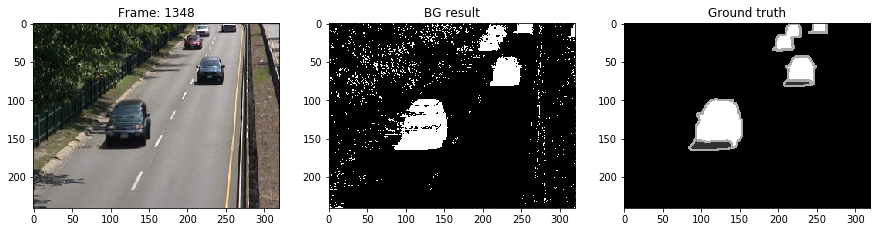


1347it [31:04,  1.41s/it]

KeyboardInterrupt: 

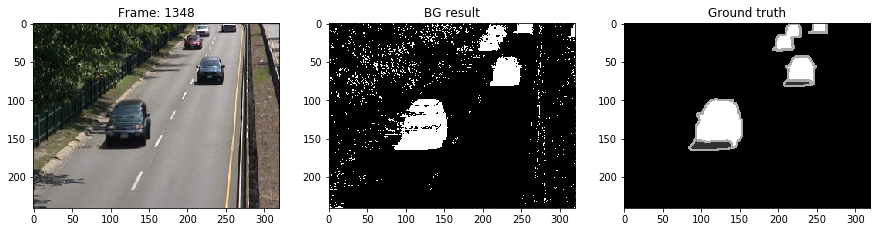

In [7]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**3. (1 балл)**

Визуально протестируйте алгоритм на видео из категории Baseline.  Покажите ключевые кадры и проанализируйте результаты.  Сделайте выводы о плюсах и минусах алгоритма. 

highway
office
pedestrians
PETS2006


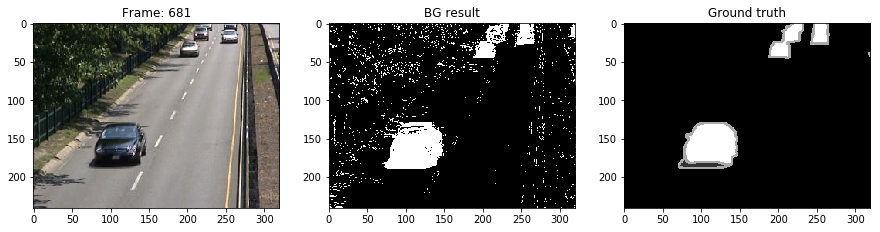

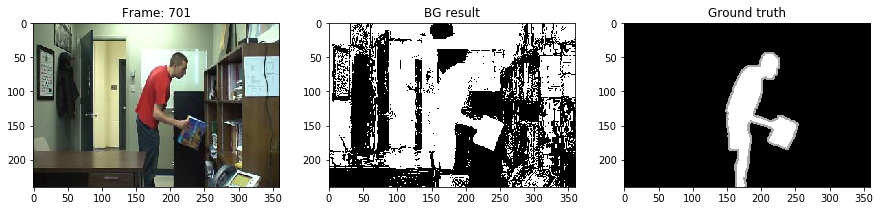

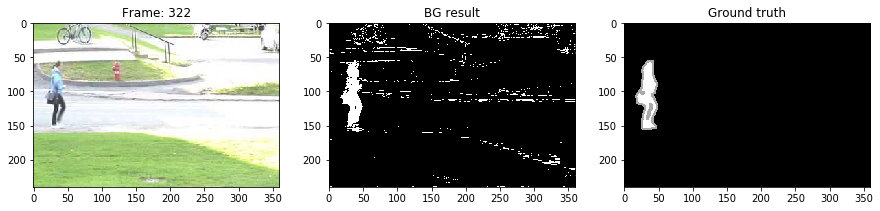

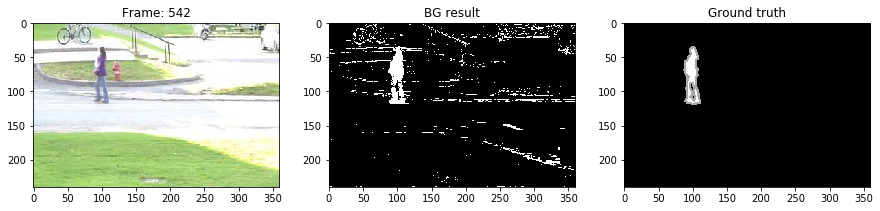

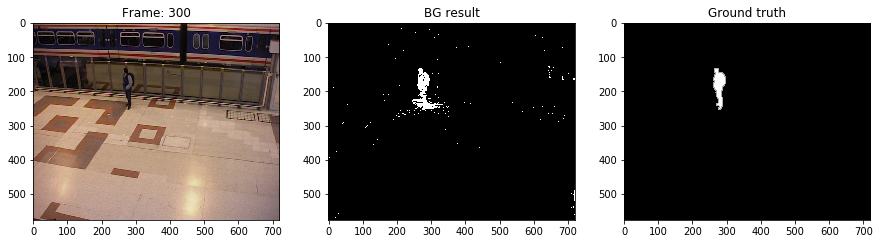

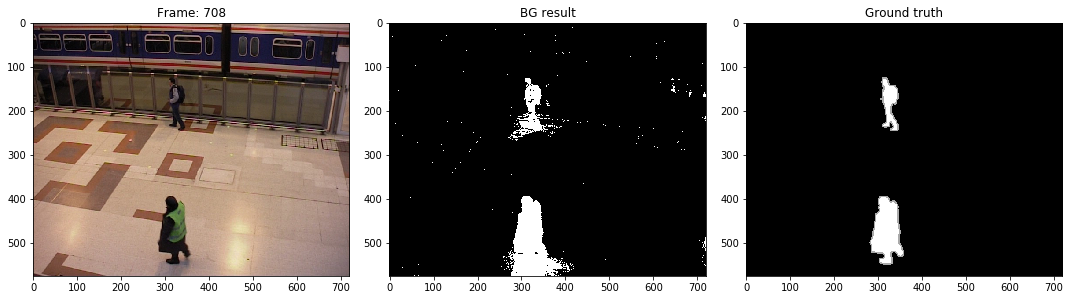

In [25]:
baseline_paths = os.listdir("dataset/baseline")
numbers = [[681], [701], [322, 542], [300, 708]]

for i, path in enumerate(baseline_paths):
    image_gen = image_generator(os.path.join("dataset/baseline", path))
    print(path)
    bg_substractor = Vibe(sample_amount=200, radius=20, K=2, subsampling_time=6)
    bg_substractor.initialize(image_gen.__next__()[1])
    for numb, frame, mask, gt in apply_bg_substractor(bg_substractor, image_gen):
        if numb in numbers[i]:
            ind = numbers[i].index(numb)
            plot_bg_result(numb, frame, mask, gt)
            if ind == len(numbers[i]) - 1:
                break

plt.tight_layout()

**Выводы:** С некоторым шумом данный алгоритм правильно определяет фон и объекты. На наборе данных 'office' параметры подобраны неудачно, результаты на других наборах лучше.

## Часть 2

В этой части задания вам необходимо реализовать метрики оценки качества вычитания фона, протестировать реализованый вами алгоритм Vibe на категории Baseline датасета ChangeDetection2014.


**4. (0.5 балла)**

Реализуйте следущие метрики:
\begin{equation*}
\begin{array}{l}
Precision = \frac{TP}{TP + FP} \\
Recall = \frac{TP}{TP + FN} \\
F_1{\text -}score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{array}
\end{equation*}

In [20]:
def precision(confusion_matrix):
    """
    Compute the precision

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    return confusion_matrix[3] / (confusion_matrix[3] + confusion_matrix[1])


def recall(confusion_matrix):
    """
    Compute the recall

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    return confusion_matrix[3] / (confusion_matrix[3] + confusion_matrix[2])


def f1_score(confusion_matrix):
    """
    Compute the f1_score

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    pr = precision(confusion_matrix)
    r = recall(confusion_matrix)
    return 2 * pr * r / (pr + r)

**5. (2 балла) **

Посчитайте значение метрик качества $precision$, $recall$, $f_1{\text -}score$ для всех видео из категории Baseline. Также посчитайте среднее значение этих метрик по категории. Вам необходимо достичь среднего значения $f_1{\text -}score$ более 0.8 для категории Baseline.

*Замечание 1:*  
$TP$, $FP$, $FN$, $TP$ надо аккумулировать для всего видео, после чего надо вычислить значение метрик для каждого видео по описанным выше формулам и усреднить по всем видео из категории.

*Замечание 2:*  
В разметке встречаются следующие метки:
* 0 : Static
* 50 : Hard shadow
* 85 : Outside region of interest
* 170 : Unknown motion (usually around moving objects, due to semi-transparency and motion blur)
* 255 : Motion

При подсчет метрик качества вам необходимо учитывать только метки: 0 и 50 - это пиксели фона, и 255 - это пиксели переднего плана. Пиксели, содержащие метки 85 и 170 надо не учитывать при подсчете метрик качества.

In [28]:
precision_b = []
recall_b = []
f1_b = []
for i, path in enumerate(baseline_paths):
    image_gen = image_generator(os.path.join("dataset/baseline", path))
    confusion_matrix = np.zeros(4)
    bg_substractor = Vibe(sample_amount=200, radius=20, K=2, subsampling_time=6)
    bg_substractor.initialize(image_gen.__next__()[1])
    for numb, frame, mask, gt in apply_bg_substractor(bg_substractor, image_gen):
        confusion_matrix[0] += (mask & (gt == 255)).sum()
        confusion_matrix[1] += ((mask == False) & (gt == 255)).sum()
        confusion_matrix[2] += (mask & ((gt == 0) | (gt == 50))).sum()
        confusion_matrix[3] += ((mask == False) & ((gt == 0) | (gt == 50))).sum()
    precision_b.append(precision(confusion_matrix))
    recall_b.append(recall(confusion_matrix))
    f1_b.append(f1_score(confusion_matrix))
    print(path)
    print('precision = ', precision_b[-1], '; recall = ', recall_b[-1], '; f1-score = ', f1_b[-1])
    print()
    
print('mean precision = ', np.array(precision_b).mean())
print('mean recall = ', np.array(recall_b).mean())
print('mean f1-score = ', np.array(f1_b).mean())

highway
precision =  0.9955653850682792 ; recall =  0.9143116554092553 ; f1-score =  0.9532100925851601

office
precision =  0.9965643778526745 ; recall =  0.6093465049022434 ; f1-score =  0.756272377347455

pedestrians
precision =  0.9997297894248136 ; recall =  0.9563144145149055 ; f1-score =  0.9775402890397704

PETS2006
precision =  0.9990890400383091 ; recall =  0.9881485128775148 ; f1-score =  0.9935886604975981

mean precision =  0.9977371480960191
mean recall =  0.8670302719259798
mean f1-score =  0.9201528548674958


Комментарий: при подсчёте confusion_matrix я брала фон как класс +1, а передний план как -1, так как исследуется алгоритм вычитания фона.

## Часть 3

В этой части задания вам предстоит протестировать алгоритм, основанный на смеси гауссиан из библиотеки `opencv`. Сравнить работу этого алгоритма с алгоритмом Vibe, а также посмотреть как ведут себя алгоритмы при добавление шума различной степени на изображение.


**6. (0.5 балл)**

Посмотрите как ведет себя алгоритм `MOG2` из библиотеки `opencv`. Аналогично как из с алгоритмом Vibe провизиализируйте покадровую работу алгоритма на какой-нибудь части видео и визуально оцените качество работы взависимости от параметров `history` и `varThreshhold`, параметр `detectShadows` установите равным False. Какие выводы вы можете сделать?

In [43]:
from cv2 import createBackgroundSubtractorMOG2

mog2 = createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=False)
image_gen = image_generator("dataset/baseline/highway")

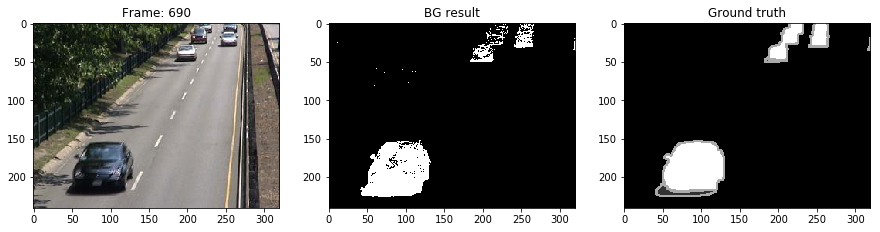










690it [07:50,  1.36it/s]

KeyboardInterrupt: 

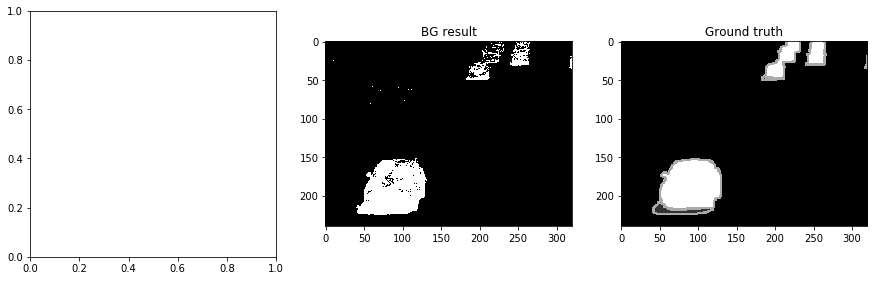

In [44]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**Выводы:** Если зафиксировать параметр varThreshold и увеличивать параметр history (начиная с 1), то шум на фоне, определённый как пиксели объектов переднего плана, будет уменьшаться. Если зафиксировать параметр history и увеличивать параметр varThreshold (начиная с 1), то шум на фоне тоже будет уменьшаться, однако, при большом varThreshold (около 50 и выше) объекты переднего плана будут с пробелами.

**7. (1 балл)**

Выберите один кадр из набора ключевых кадров, отобранных ключевых кадрах в пункте 3 и добавляйте к
нему попиксельно независимый гауссовский шум. Проанализируйте результаты вычитания фона обоими методами для шума различной интенсивности. Подберите параметры алгоритмов для работы с зашумленными изображениями.  Визуализируйте результаты работы обоих алгоритмов а также вычислите $f_1{\text -}score$ для всех экспрериментов. Сделайте выводы.

*Замечание 1:*  
Сравнение проводите честно, подавайте в алгоритм одинаковое кол-во впереди идущих кадров, необходимых для настройки внутренних параметров алгоритма.

*Замечание 2:*  
Ко всем кадрам, подаваемым в модель, необходимо также добавлять гауссовский шум.

In [84]:
def noise_image_generator(dirpath, sigma, first_frame=1, last_frame=None):
    input_format_name = 'input/in{:06d}.jpg'
    gt_format_name = 'groundtruth/gt{:06d}.png'
    
    numb = first_frame
    while (last_frame is None) or numb <= last_frame:
        input_path = os.path.join(dirpath, input_format_name.format(numb))
        gt_path = os.path.join(dirpath, gt_format_name.format(numb))

        if os.path.exists(input_path):
            input_image = skimage.io.imread(input_path)
            gt_image = skimage.io.imread(gt_path)
            if len(input_image.shape) == 2:
                input_image = input_image[..., np.newaxis]
            noise = np.random.normal(scale=sigma, size=input_image.shape).astype(input_image.dtype)
            input_image += noise
            input_image[input_image < 0] = 0
            input_image[input_image > 255] = 255
            yield numb, input_image, gt_image
        else:
            break
        numb += 1
        

def get_mog2_result(sigma):
    """
    Apply MOG2 algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    final = 322
    np.random.seed(42)
    image_gen = noise_image_generator("dataset/baseline/pedestrians", sigma, final-201, final)
    mog2 = createBackgroundSubtractorMOG2(history=200, varThreshold=50, detectShadows=False)
    for numb, frame, mask, gt in apply_bg_substractor(mog2, image_gen):
        pass
    return frame, mask, gt
    

def get_vibe_result(sigma):
    """
    Apply ViBe algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    final = 322
    np.random.seed(42)
    image_gen = noise_image_generator("dataset/baseline/pedestrians", sigma, final-201, final)
    bg_substractor = Vibe(sample_amount=200, radius=20, K=2, subsampling_time=6)
    bg_substractor.initialize(image_gen.__next__()[1])
    for numb, frame, mask, gt in apply_bg_substractor(bg_substractor, image_gen):
        pass
    return frame, mask, gt


def get_confusion_matrix(mask, gt):
    confusion_matrix = np.empty(4)
    confusion_matrix[0] = (mask & (gt == 255)).sum()
    confusion_matrix[1] = ((mask == False) & (gt == 255)).sum()
    confusion_matrix[2] = (mask & ((gt == 0) | (gt == 50))).sum()
    confusion_matrix[3] = ((mask == False) & ((gt == 0) | (gt == 50))).sum()
    return confusion_matrix

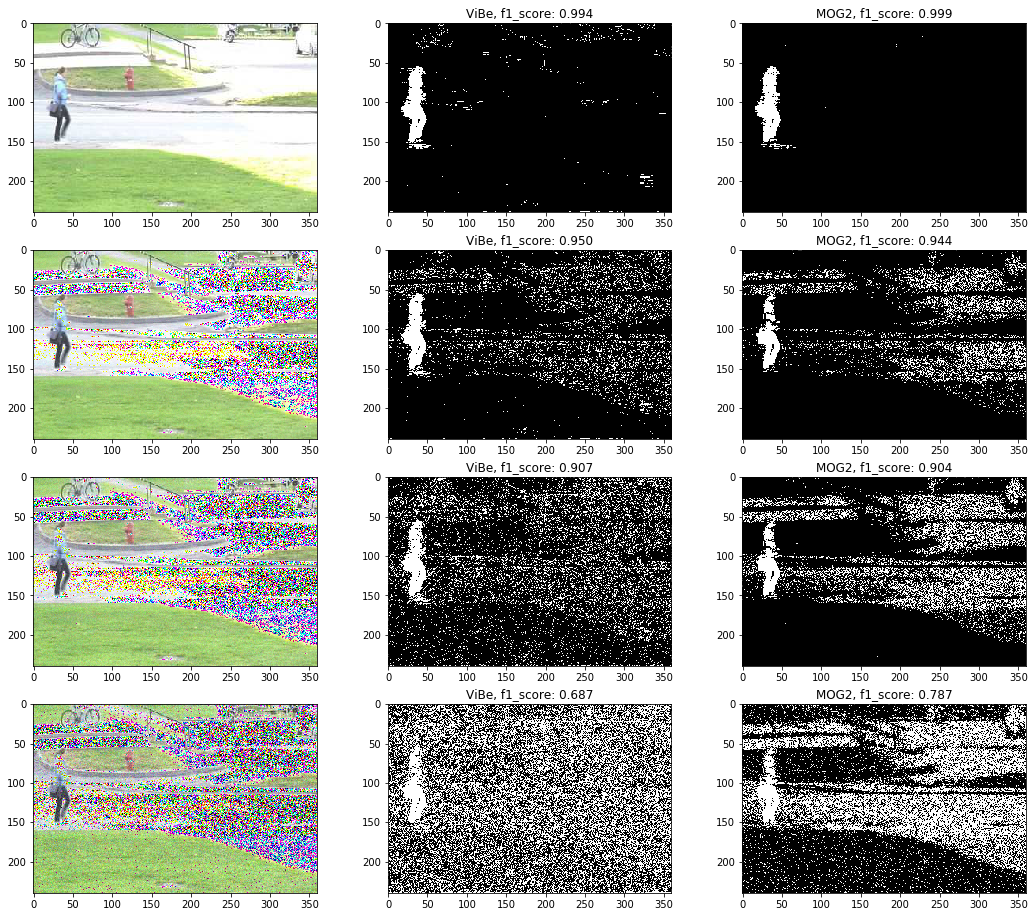

In [73]:
sigmas = [0, 5, 10, 20]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    frame, mog2_mask, gt = get_mog2_result(sigma)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("ViBe, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(vibe_mask, gt))))
    
    axs[i][2].imshow(mog2_mask, cmap='gray')
    axs[i][2].set_title("MOG2, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(mog2_mask, gt))))

**Выводы:** Шум на результатах увеличивается с увеличением sigma и значение f1-score падает. При данных параметрах алгоритмов MOG2 показывает результаты лучше.

**8. (1 балл)**

Предложите метод борьбы с шумом на карте "фон-объект" и проанализируйте его эффективность. Сравнивайте результаты по какой-нибудь метрики качества, например $f_1{\text -}score$.

*Замечание:*

Можно использовать любые функции обработки изображений из библиотек `opencv` и `skimage`.

In [101]:
def postprocess(mask):
    """
    Postprocessing foreground mask
    """
    mask_copy = mask.copy()
    p = 4
    for i in range(1, mask.shape[0] - 1):
        for j in range(1, mask.shape[1] - 1):
            if mask_copy[i, j] and (mask[i - 1: i + 2, j - 1: j + 2].sum() - 1) < p:
                mask_copy[i, j] = False
    return mask_copy

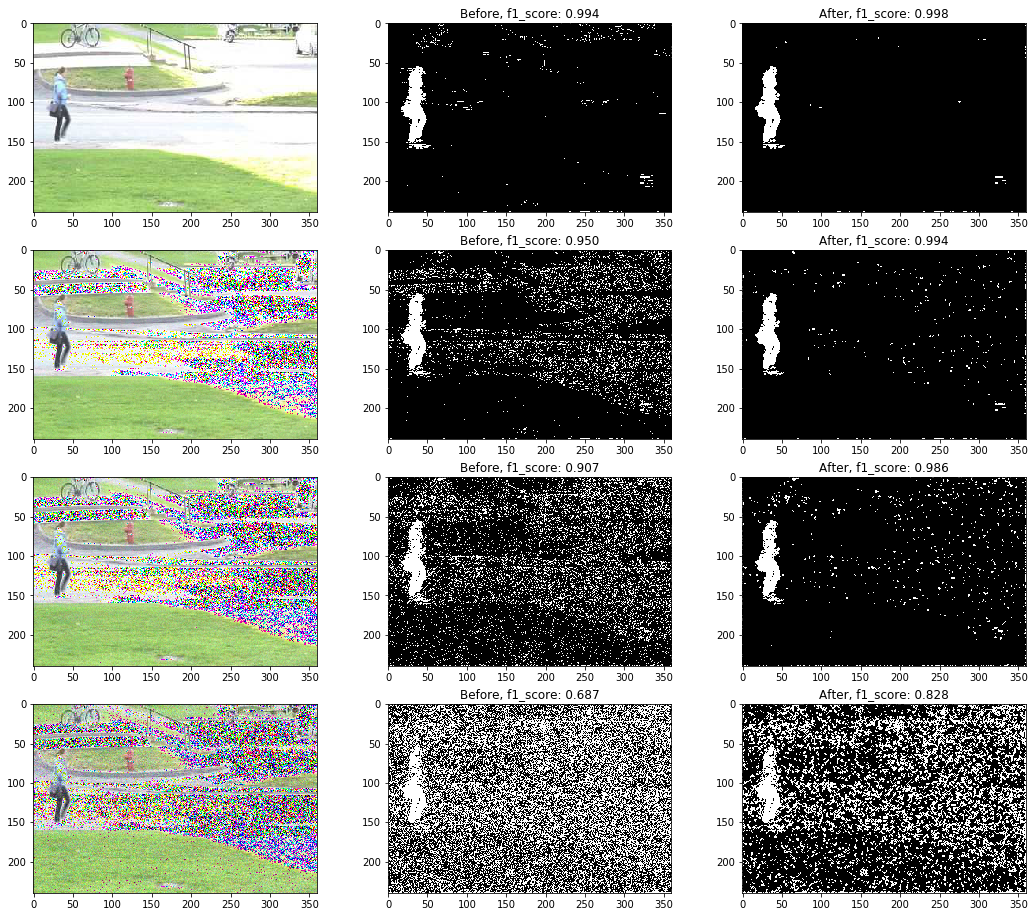

In [102]:
sigmas = [0, 5, 10, 20]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    process_mask = postprocess(vibe_mask)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("Before, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(vibe_mask, gt))))
    
    axs[i][2].imshow(process_mask, cmap='gray')
    axs[i][2].set_title("After, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(process_mask, gt))))

**Выводы:** Для подавления шума был использован следующий алгоритм: для каждого пикселя переднего плана рассматриваются его 8 соседей, если среди них меньше p являются пикселями переднего плана, то этот пиксель становится пикселем фона, в данном случае p=4. Даже такой простой метод позволяет неплохо повысить качество.